# DeepFool ATTACK

In [1]:
# !pip install facenet-pytorch
# !pip install Pillow
# !pip install -q tensorflow==2.0.0
# !pip install adversarial-robustness-toolbox[all]
# !pip install matplotlib

### *Import*



### initialization

In [12]:
import os
import re
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
import torch
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from art.estimators.classification import PyTorchClassifier
import tensorflow as tf
from matplotlib import pyplot as plt
from utils import load_test_image_NN2_preprocessed

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = str(device)
print(device)

cuda


In [13]:
if device in 'cuda':
    print("Import Inception.Inception")
    import inception
    nn1 = inception.InceptionResnetV1(pretrained='vggface2').eval()
    nn1 .classify = True
elif device == "cpu":
    print("Import Facenet.Inception")
    from facenet_pytorch import InceptionResnetV1
    nn1  = InceptionResnetV1(pretrained='vggface2').eval()
    nn1.classify = True

nn1.to(device)

model_nn1 = PyTorchClassifier(nn1,input_shape=[160,160], loss=CrossEntropyLoss(),nb_classes=8631, device_type=device) #This class implements a classifier with the PyTorch framework.


Import Inception.Inception


In [14]:
from RESNET import ResNet
from utils import get_labels
from utils import load_state_dict

nn2 = ResNet.resnet50(num_classes=8631, include_top=True)


load_state_dict(nn2,'resnet50_scratch_weight.pkl')
nn2.eval()

model_nn2 = PyTorchClassifier(nn2,input_shape=[224,224], loss=CrossEntropyLoss(),nb_classes=8631, device_type=device)

LABELS = get_labels()

### Untargeted Attack on all test set

In [15]:
from art.attacks.evasion import DeepFool
import os
import re
import numpy as np
from utils import load_image_NN1, load_test_image_NN2

dataset_dir = "test_set_cropped/"
#eps_step =[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9]
eps_step =[0.000005, 0.00001, 0.00015, 0.002, 0.025, 0.03, 0.35, 0.4, 0.45, 0.5, 1, 2, 5, 8]
max_iter = [1,5]


accuracy_for_eps_nn1 = np.zeros((len(max_iter),len(eps_step)))
perturbation_for_eps_nn1 = np.zeros((len(max_iter),len(eps_step)))
correct_predictions_nn1 = 0

accuracy_for_eps_nn2 = np.zeros((len(max_iter),len(eps_step)))
perturbation_for_eps_nn2 = np.zeros((len(max_iter),len(eps_step)))
correct_predictions_nn2 = 0

accuracy_for_eps_nn2_preprocessed=np.zeros((len(max_iter),len(eps_step)))
correct_predictions_nn2_preprocessed=0


total_images = 0
print("Inizio Attacco DeepFool NON-TARGETED")

# Ensure models and labels are defined and loaded
# model_nn1, model_nn2, LABELS should be defined here
for i in range(len(max_iter)):
    for j in range(len(eps_step)):
        correct_predictions_nn1 = 0
        correct_predictions_nn2 = 0
        correct_predictions_nn2_preprocessed=0
        total_images = 0

        perturbations = []
        attack = DeepFool(classifier=model_nn1, epsilon=eps_step[j], max_iter=max_iter[i])

        print(f"**** Attacco con eps: {eps_step[j]} ****")
        for filename in os.listdir(dataset_dir):
            if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                person_path = os.path.join(dataset_dir, filename)
                test_img = load_image_NN1(person_path, device).numpy()
                test_images_adv = attack.generate(test_img)
                # nn1_predictions = model_nn1.predict(test_images_adv)
                # test_images_NN2 = load_test_image_NN2(test_images_adv)
                # nn2_predictions = model_nn2.predict(test_images_NN2)

                # test_images_NN2_preprocessed= load_test_image_NN2_preprocessed(test_images_adv)
                # nn2_prediction_preprocessed=model_nn2.predict(test_images_NN2_preprocessed)

                # correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
                perturbations.append(np.linalg.norm(test_images_adv - test_img))

                # predicted_label_nn1 = LABELS[np.array(nn1_predictions.argmax())]
                # predicted_label_nn2 = LABELS[np.array(nn2_predictions.argmax())]
                # predicted_label_nn2_preprocessed= LABELS[np.array(nn2_prediction_preprocessed.argmax())]

                total_images += 1

                # if correct_label in predicted_label_nn1:
                #     correct_predictions_nn1 += 1

                # if correct_label in predicted_label_nn2:
                #     correct_predictions_nn2 += 1

                # if correct_label in predicted_label_nn2_preprocessed:
                #     correct_predictions_nn2_preprocessed +=1
                if total_images == 500:
                    print("SEI A 500 IMMAGINI PER max_iter: {} e eps: {}".format(max_iter[i],eps_step[j]))
        if total_images != 0:
            perturbation_mean = np.mean(perturbations)
            perturbation_for_eps_nn1[i][j]=perturbation_mean
        
            # accuracy_nn1 = correct_predictions_nn1 / total_images
            # accuracy_for_eps_nn1[i][j]=accuracy_nn1

            # accuracy_nn2 = correct_predictions_nn2/ total_images
            # accuracy_for_eps_nn2[i][j]=accuracy_nn2

            # accuracy_nn2_preprocessed= correct_predictions_nn2_preprocessed/total_images
            # accuracy_for_eps_nn2_preprocessed[i][j]=accuracy_nn2_preprocessed

            # print(f"Accuracy Inception ResNet for eps {eps_step[j]}: {accuracy_nn1}")
            # print(f"Accuracy Resnet50 for eps {eps_step[j]}: {accuracy_nn2}")
            # print(f"Average perturbation for eps {eps_step[j]}: {perturbation_mean}")


Inizio Attacco DeepFool NON-TARGETED
**** Attacco con eps: 5e-06 ****


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


SEI A 500 IMMAGINI PER max_iter: 1 e eps: 5e-06


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


**** Attacco con eps: 1e-05 ****


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


SEI A 500 IMMAGINI PER max_iter: 1 e eps: 1e-05


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


**** Attacco con eps: 0.00015 ****


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


SEI A 500 IMMAGINI PER max_iter: 1 e eps: 0.00015


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


**** Attacco con eps: 0.002 ****


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


SEI A 500 IMMAGINI PER max_iter: 1 e eps: 0.002


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


**** Attacco con eps: 0.025 ****


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


SEI A 500 IMMAGINI PER max_iter: 1 e eps: 0.025


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


**** Attacco con eps: 0.03 ****


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


SEI A 500 IMMAGINI PER max_iter: 1 e eps: 0.03


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


**** Attacco con eps: 0.35 ****


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


SEI A 500 IMMAGINI PER max_iter: 1 e eps: 0.35


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


**** Attacco con eps: 0.4 ****


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


SEI A 500 IMMAGINI PER max_iter: 1 e eps: 0.4


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


**** Attacco con eps: 0.45 ****


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


SEI A 500 IMMAGINI PER max_iter: 1 e eps: 0.45


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


**** Attacco con eps: 0.5 ****


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


SEI A 500 IMMAGINI PER max_iter: 1 e eps: 0.5


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


**** Attacco con eps: 1 ****


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


SEI A 500 IMMAGINI PER max_iter: 1 e eps: 1


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


**** Attacco con eps: 2 ****


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


SEI A 500 IMMAGINI PER max_iter: 1 e eps: 2


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


**** Attacco con eps: 5 ****


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


SEI A 500 IMMAGINI PER max_iter: 1 e eps: 5


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


**** Attacco con eps: 8 ****


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


SEI A 500 IMMAGINI PER max_iter: 1 e eps: 8


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


**** Attacco con eps: 5e-06 ****


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


SEI A 500 IMMAGINI PER max_iter: 5 e eps: 5e-06


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


**** Attacco con eps: 1e-05 ****


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


SEI A 500 IMMAGINI PER max_iter: 5 e eps: 1e-05


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


**** Attacco con eps: 0.00015 ****


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


SEI A 500 IMMAGINI PER max_iter: 5 e eps: 0.00015


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


**** Attacco con eps: 0.002 ****


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


SEI A 500 IMMAGINI PER max_iter: 5 e eps: 0.002


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


**** Attacco con eps: 0.025 ****


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it]


SEI A 500 IMMAGINI PER max_iter: 5 e eps: 0.025


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]


**** Attacco con eps: 0.03 ****


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]


SEI A 500 IMMAGINI PER max_iter: 5 e eps: 0.03


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


**** Attacco con eps: 0.35 ****


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.93s/it]


SEI A 500 IMMAGINI PER max_iter: 5 e eps: 0.35


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


**** Attacco con eps: 0.4 ****


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


SEI A 500 IMMAGINI PER max_iter: 5 e eps: 0.4


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


**** Attacco con eps: 0.45 ****


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.71s/it]


SEI A 500 IMMAGINI PER max_iter: 5 e eps: 0.45


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


**** Attacco con eps: 0.5 ****


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


SEI A 500 IMMAGINI PER max_iter: 5 e eps: 0.5


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


**** Attacco con eps: 1 ****


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


SEI A 500 IMMAGINI PER max_iter: 5 e eps: 1


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


**** Attacco con eps: 2 ****


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


SEI A 500 IMMAGINI PER max_iter: 5 e eps: 2


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


**** Attacco con eps: 5 ****


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


SEI A 500 IMMAGINI PER max_iter: 5 e eps: 5


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


**** Attacco con eps: 8 ****


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


SEI A 500 IMMAGINI PER max_iter: 5 e eps: 8


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


In [16]:
print(perturbation_for_eps_nn1)

[[0.79307044 0.79307473 0.79318601 0.79465318 0.81289381 0.81685913
  1.07064068 1.11029398 1.14994729 1.18960071 1.58613431 2.37920141
  4.75840282 7.13760424]
 [0.90827721 0.90830296 0.90841991 0.91010672 0.93098825 0.93554956
  1.22619045 1.27160978 1.31700742 1.36244023 1.81658804 2.72485018
  5.4497261  8.17453671]]


In [6]:
print(eps_step)

print(accuracy_for_eps_nn1)
print("\n")
print(accuracy_for_eps_nn2)
print("\n")
print(accuracy_for_eps_nn2_preprocessed)

[5e-06, 1e-05, 0.00015, 0.002, 0.025, 0.03, 0.35, 0.4, 0.45, 0.5, 1, 2, 5, 8]
[[0.191 0.191 0.191 0.191 0.185 0.184 0.105 0.095 0.083 0.074 0.035 0.017
  0.01  0.009]
 [0.023 0.023 0.023 0.023 0.021 0.021 0.015 0.015 0.014 0.014 0.01  0.01
  0.008 0.007]]


[[0.858 0.858 0.858 0.858 0.856 0.856 0.84  0.835 0.831 0.828 0.774 0.689
  0.425 0.298]
 [0.854 0.854 0.854 0.854 0.852 0.852 0.835 0.831 0.827 0.824 0.768 0.651
  0.339 0.219]]


[[0.904 0.904 0.904 0.904 0.903 0.903 0.894 0.892 0.892 0.888 0.862 0.79
  0.543 0.375]
 [0.903 0.903 0.903 0.903 0.902 0.902 0.894 0.892 0.892 0.888 0.861 0.776
  0.469 0.29 ]]


#### EVALUATION CURVE NN1

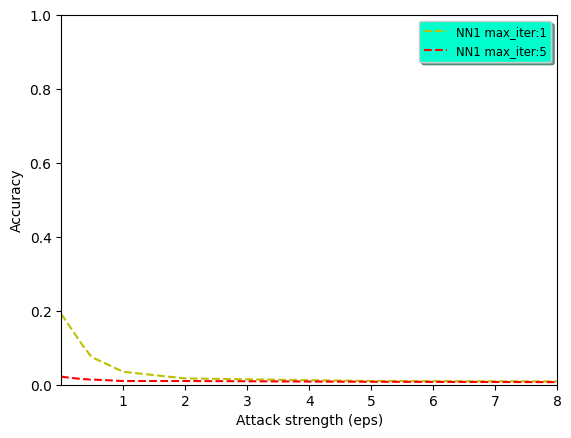

In [7]:
from matplotlib import pyplot as plt

# plot accuracy/Attack strength NN1-NN2

fig, ax = plt.subplots()

ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn1[0]), 'y--', label='NN1 max_iter:{}'.format(max_iter[0]))
ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn1[1]), 'r--', label='NN1 max_iter:{}'.format(max_iter[1]))


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

ax.set_xlim(eps_step[0], eps_step[-1])  # Imposta i limiti dell'asse x
ax.set_ylim(0,1)  # Imposta i limiti dell'asse y
plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy')

plt.show()

#### EVALUATION CURVE NN2

Text(0, 0.5, 'Accuracy')

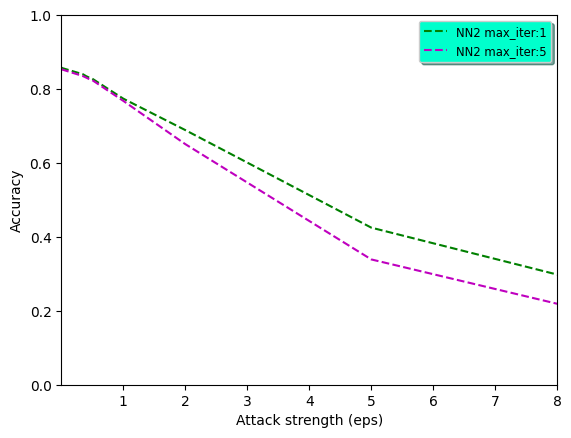

In [8]:
from matplotlib import pyplot as plt

# plot accuracy/Attack strength NN1-NN2

fig, ax = plt.subplots()

ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn2[0]), 'g--', label='NN2 max_iter:{}'.format(max_iter[0]))
ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn2[1]), 'm--', label='NN2 max_iter:{}'.format(max_iter[1]))

legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

ax.set_xlim(eps_step[0], eps_step[-1])  # Imposta i limiti dell'asse x
ax.set_ylim(0,1)  # Imposta i limiti dell'asse y
plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy')

#### ACCURACY/PERTURBAZIONE NN1

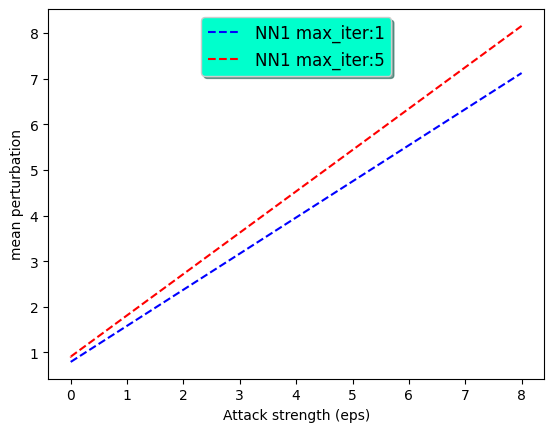

In [9]:


fig, ax = plt.subplots()
ax.plot(np.array(eps_step), np.array(perturbation_for_eps_nn1[0]), 'b--', label='NN1 max_iter:{}'.format(max_iter[0]))
ax.plot(np.array(eps_step), np.array(perturbation_for_eps_nn1[1]), 'r--', label='NN1 max_iter:{}'.format(max_iter[1]))
legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('mean perturbation')
plt.show()

#### EVALUATION CURVE NN2 PREPROCESSED

In [ ]:
# plot accuracy/Attack strength NN1-NN2

fig, ax = plt.subplots()

ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn2_preprocessed[0]), 'g--', label='NN2 Prep. max_iter:{}'.format(max_iter[0]))
ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn2_preprocessed[1]), 'm--', label='NN2 Prep. max_iter:{}'.format(max_iter[1]))

legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

ax.set_xlim(eps_step[0], eps_step[-1])  # Imposta i limiti dell'asse x
ax.set_ylim(0,1)  # Imposta i limiti dell'asse y
plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy')

#### CONFRONTO NN1 e NN2

In [ ]:
fig, ax = plt.subplots()
ax.plot(eps_step, np.array(accuracy_for_eps_nn1[0][0]), 'black', label='NN1 max_iter: 1')
ax.plot(eps_step, np.array(accuracy_for_eps_nn1[1][0]), 'red', label='NN1 max_iter: 5')
ax.plot(eps_step, np.array(accuracy_for_eps_nn2[0][0]), 'blue', label='NN2 max_iter: 1')
ax.plot(eps_step, np.array(accuracy_for_eps_nn2[1][0]), 'violet', label='NN2 max_iter: 5')


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')
plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')

#### CONFRONTO NN1 NN2 NN2Prep.


In [ ]:
fig, ax = plt.subplots()
ax.plot(eps_step, np.array(accuracy_for_eps_nn1[1][0]), 'red', label='NN1 max_iter: 5')
ax.plot(eps_step, np.array(accuracy_for_eps_nn2[1][0]), 'violet', label='NN2 max_iter: 5')
ax.plot(eps_step, np.array(accuracy_for_eps_nn2_preprocessed[1][0]), 'orange', label='NN2 Preprocessed max_iter: 5')


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')
plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')

### Single sample Untargeted attack

In [10]:
from art.attacks.evasion import DeepFool

epsilon = 4
max_iter = 5

attack = DeepFool(classifier=model_nn1, epsilon=epsilon, max_iter=max_iter)

In [11]:
from utils import load_image_NN1
dataset_dir = "test_set_cropped/"
filename = "Boris_Johnson_1_face_0.jpg"

person_path = os.path.join(dataset_dir, filename)
test_img = load_image_NN1(person_path,device)
test_img_numpy = test_img.numpy()
test_images_adv = attack.generate(test_img_numpy)

nn1_predictions = model_nn1.predict(test_images_adv)
perturbation = np.mean(np.abs((test_images_adv - test_img_numpy)))
print('Average perturbation: {:4.2f}'.format(perturbation))


test_images_NN2 = load_test_image_NN2_preprocessed(test_images_adv)
nn2_predictions = model_nn2.predict(test_images_NN2)



predicted_label_nn1= LABELS[np.array(nn1_predictions.argmax())]
predicted_label_nn2 = LABELS[np.array(nn2_predictions.argmax())]
print("NN1{} con probabilità {}".format(predicted_label_nn1,nn1_predictions[0][nn1_predictions.argmax()]))
print("NN2{} con probabilità {}".format(predicted_label_nn2,nn2_predictions[0][nn2_predictions.argmax()]))


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Average perturbation: 0.02
NN1 Miguel_Herrera con probabilità 8.963422775268555
NN2 Boris_Johnson con probabilità 12.627102851867676


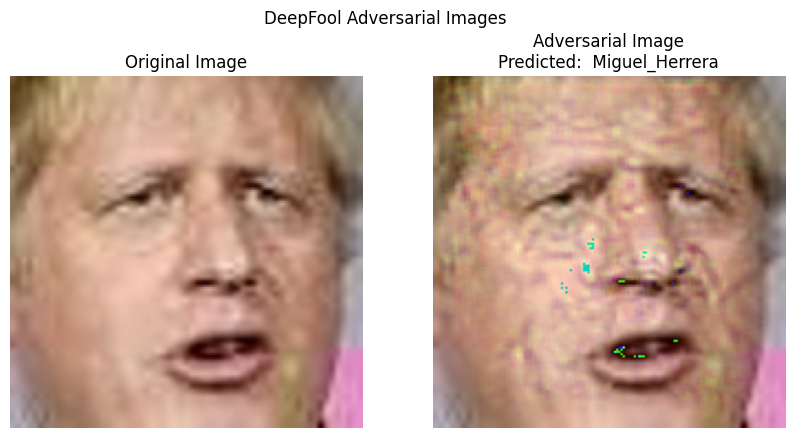

In [12]:
# Prepara le immagini per la visualizzazione
# Rimuovi la dimensione batch extra e converti nel formato channels-last
test_images_adv = np.squeeze(test_images_adv, axis=0)
test_images_adv = np.transpose(test_images_adv, (1, 2, 0))

# Converti le immagini in uint8 per la visualizzazione
if test_img_numpy.dtype != np.uint8:
    test_img_numpy = (test_img_numpy * 255).astype(np.uint8)
    test_img_numpy = np.squeeze(test_img_numpy, axis=0)  # Rimuovi la dimensione batch extra
    test_img_numpy = np.transpose(test_img_numpy, (1, 2, 0))

if test_images_adv.dtype != np.uint8:
    test_images_adv = (test_images_adv * 255).astype(np.uint8)

# Visualizza le immagini affiancate con Matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Mostra l'immagine originale
ax1.imshow(test_img_numpy)
ax1.set_title('Original Image')
ax1.axis('off')

# Mostra l'immagine avversaria
ax2.imshow(test_images_adv)
ax2.set_title(f'Adversarial Image\nPredicted: {predicted_label_nn1}')
ax2.axis('off')

# Mostra la figura
plt.suptitle("DeepFool Adversarial Images")
plt.show()


In [ ]:

eps = [5e-06, 1e-05, 0.00015, 0.002, 0.025, 0.03, 0.35, 0.4, 0.45, 0.5, 1, 2, 5, 8]
accuracy = [[0.904, 0.904, 0.904, 0.904,, 0.903 0.903, 0.894, 0.892, 0.892, 0.888, 0.862, 0.79, 0.543, 0.375]
 ,[0.903, 0.903, 0.903, 0.903, 0.902, 0.902, 0.894, 0.892, 0.892, 0.888, 0.861, 0.776, 0.469, 0.29]]

fig, ax = plt.subplots()
ax.plot(perturbation_for_learning_rate_nn1[0][0],accuracy_for_learning_rate_nn1, 'b', label='NN1 max_iter: 3')
ax.plot(perturbation_for_learning_rate_nn1[0][0],accuracy_for_learning_rate_nn2, 'r', label='NN1 max_iter: 16')
#ax.plot(np.array(perturbation_for_learning_rate_nn1[1][0]), np.array(perturbation_for_learning_rate_nn1[1][0]), 'r--', label='NN1 max_iter: 16')

legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')
  # Imposta i limiti dell'asse x

plt.ylabel('Accuracy')
plt.xlabel('Perturbation')
plt.show()

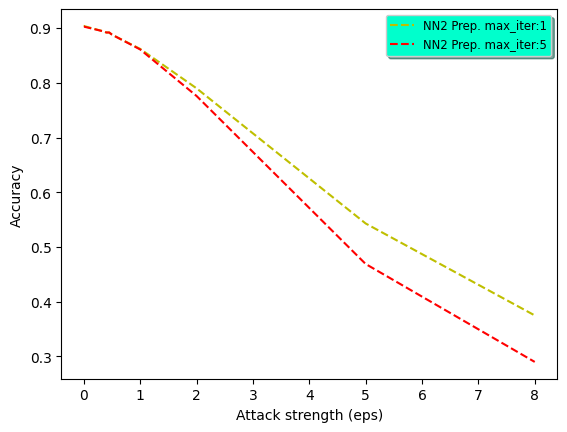

In [11]:
prep = [[0.904, 0.904, 0.904, 0.904, 0.903, 0.903, 0.894, 0.892, 0.892, 0.888, 0.862, 0.79,
  0.543, 0.375],
 [0.903, 0.903, 0.903, 0.903, 0.902, 0.902, 0.894, 0.892, 0.892, 0.888, 0.861, 0.776,
  0.469, 0.29]]

from matplotlib import pyplot as plt

# plot accuracy/Attack strength NN1-NN2

fig, ax = plt.subplots()

ax.plot(np.array(eps_step), np.array(prep[0]), 'y--', label='NN2 Prep. max_iter:{}'.format(max_iter[0]))
ax.plot(np.array(eps_step), np.array(prep[1]), 'r--', label='NN2 Prep. max_iter:{}'.format(max_iter[1]))


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

  # Imposta i limiti dell'asse y
plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy')

plt.show()

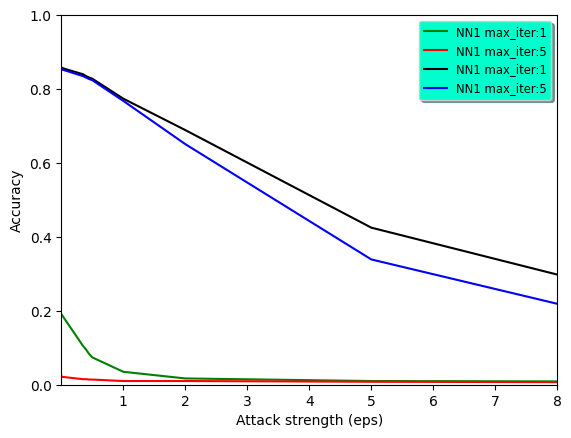

In [9]:
nn1 = [[0.191, 0.191, 0.191, 0.191, 0.185, 0.184, 0.105, 0.095, 0.083, 0.074, 0.035, 0.017,
  0.01,  0.009],
 [0.023, 0.023, 0.023, 0.023, 0.021 , 0.021, 0.015, 0.015, 0.014, 0.014, 0.01,  0.01,
  0.008, 0.007]]


nn2 = [[0.858, 0.858, 0.858, 0.858, 0.856, 0.856, 0.84,  0.835, 0.831, 0.828, 0.774, 0.689,
  0.425, 0.298],
 [0.854, 0.854, 0.854, 0.854, 0.852, 0.852, 0.835, 0.831, 0.827, 0.824, 0.768, 0.651,
  0.339, 0.219]]





fig, ax = plt.subplots()

ax.plot(np.array(eps_step), np.array(nn1[0]), 'green', label='NN1 max_iter:{}'.format(max_iter[0]))
ax.plot(np.array(eps_step), np.array(nn1[1]), 'red', label='NN2 max_iter:{}'.format(max_iter[1]))

ax.plot(np.array(eps_step), np.array(nn2[0]), 'black', label='NN1 max_iter:{}'.format(max_iter[0]))
ax.plot(np.array(eps_step), np.array(nn2[1]), 'blue', label='NN2 max_iter:{}'.format(max_iter[1]))


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

ax.set_xlim(eps_step[0], eps_step[-1])  # Imposta i limiti dell'asse x
ax.set_ylim(0,1)  # Imposta i limiti dell'asse y
plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy')

plt.show()